In [1]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import chardet


In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rushikesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushikesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rushikesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rushikesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Step 1: Read and preprocess data
def preprocess_text(text):
    # Convert text to lowercase
    lower_text = text.lower()
    
    cleaned_text = lower_text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokenized_words = word_tokenize(cleaned_text, "english")

    # Remove stopwords
    filtered_words = []
    for word in tokenized_words: 
      if word not in stopwords.words('english'):
        filtered_words.append(word)

    # Lemmatize words
    lemmatized_words = []
    for word in filtered_words:
      word = WordNetLemmatizer().lemmatize(word)
      lemmatized_words.append(word)

    # Join the lemmatized words back into a string
    preprocessed_text = ' '.join(lemmatized_words)
    return preprocessed_text

In [4]:
# Step 2: Load dataset and train classifier
with open('test.csv', 'rb') as file:
    encoding = chardet.detect(file.read())['encoding']
df = pd.read_csv('test.csv', encoding=encoding)
df = df.dropna()
df = df.drop(df.columns[[0,3,4,5,6,7,8]],axis = 1)
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,sentiment,preprocessed_text
0,Last session of the day http://twitpic.com/67ezh,neutral,last session day httptwitpiccom67ezh
1,Shanghai is also really exciting (precisely -...,positive,shanghai also really exciting precisely skyscr...
2,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...
3,happy bday!,positive,happy bday
4,http://twitpic.com/4w75p - I like it!!,positive,httptwitpiccom4w75p like


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], df['sentiment'], test_size=0.2, random_state=42)
svm_classifier = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))
svm_classifier.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(kernel='linear'))])

In [6]:
# Step 3: Use SentimentIntensityAnalyzer for predictions
sid = SentimentIntensityAnalyzer()

In [7]:
# Step 6: Ensure predictions have the correct length
X_all = df['preprocessed_text']
y_pred_svm = svm_classifier.predict(X_all)
y_pred_vader_all = []

for text in X_all:
    sentiment_scores = sid.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        y_pred_vader_all.append('positive')
    elif sentiment_scores['compound'] <= -0.05:
        y_pred_vader_all.append('negative')
    else:
        y_pred_vader_all.append('neutral')
        
positive_scores = []
negative_scores = []
neutral_scores = []

for text in X_all:
    sentiment_scores = sid.polarity_scores(text)
    positive_scores.append(sentiment_scores['pos'])
    negative_scores.append(sentiment_scores['neg'])
    neutral_scores.append(sentiment_scores['neu'])

In [8]:
results_df = pd.DataFrame({
    'Original Text': df['text'],
    'Preprocessed Text': df['preprocessed_text'],
    'Positive Polarity Score': positive_scores,
    'Negative Polarity Score': negative_scores,
    'Neutral Polarity Score': neutral_scores,
    'SVM Predictions': y_pred_svm,
    'Sentiment Analyzer Predictions': y_pred_vader_all
})

# Step 8: Save DataFrame to CSV file
results_df.to_csv('predictions.csv', index=False)

print("CSV file containing predictions saved successfully.")

CSV file containing predictions saved successfully.


In [15]:
user_input = input("Enter your text: ")
preprocessed_input = preprocess_text(user_input)

# Step 5: Make predictions using SVM classifier
svm_prediction = svm_classifier.predict([preprocessed_input])[0]

# Step 6: Make predictions using SentimentIntensityAnalyzer (VADER)
sentiment_scores = sid.polarity_scores(preprocessed_input)
if sentiment_scores['compound'] >= 0.05:
    vader_prediction = 'positive'
elif sentiment_scores['compound'] <= -0.05:
    vader_prediction = 'negative'
else:
    vader_prediction = 'neutral'
    

print("\nUser Input: ", user_input)
print("\nPreprocessed Text: ", preprocessed_input)
print("\nPrediction using SVM classifier: ", svm_prediction)    
print("\nPrediction using SentimentIntensityAnalyzer: ", vader_prediction)


User Input:  Most of us have childhood memories of gaping at our elders in wonder when they narrated to us the amusing fables of Aesop, the picturesque fairy tales, the funny anecdotes, the lyrical short stories, and so on. Classic bedtime stories take us into the world of imagination. These short stories are identified with brevity and compact narrative. Vedantu brings forth some of the most amazing kids' stories with colourful illustrations to make the most of the leisure reading of kids

Preprocessed Text:  u childhood memory gaping elder wonder narrated u amusing fable aesop picturesque fairy tale funny anecdote lyrical short story classic bedtime story take u world imagination short story identified brevity compact narrative vedantu brings forth amazing kid story colourful illustration make leisure reading kid

Prediction using SVM classifier:  positive

Prediction using SentimentIntensityAnalyzer:  positive


In [10]:
from collections import Counter

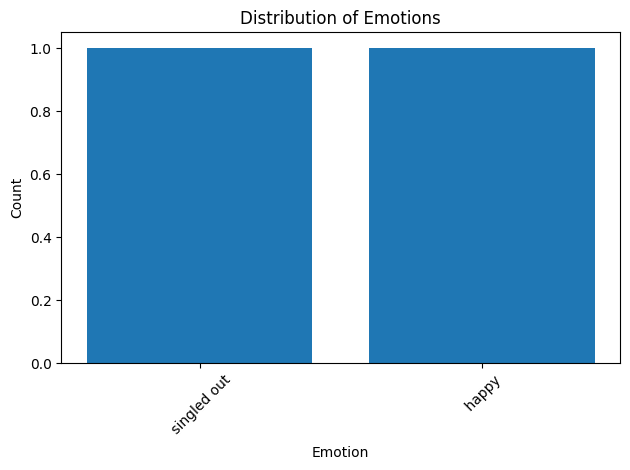

In [11]:
emotion_list = []
with open('emotions.txt', 'r') as file:
    for line in file:
        clear_line = line.replace("\n", '').replace(",", '').replace("'", '').strip()
        word, emotion = clear_line.split(':')

        if word in preprocessed_input:
            emotion_list.append(emotion)

# Count the occurrences of each emotion
emotion_counter = Counter(emotion_list)

# Plot the bar graph
plt.bar(emotion_counter.keys(), emotion_counter.values())
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('emotions_bar_graph.png')
plt.show()

In [12]:
# translator = Translator()
# # Example of user input and prediction
# user_input = input("Enter your text (in any language): ")

# # Translate user input to English
# try:
#     translated_input = translator.translate(user_input, src='auto', dest='en').text
#     if not translated_input:
#         print("An error occurred during translation. Please try again later.")
#     else:
#         preprocessed_input = preprocess_text(translated_input)
#         # Continue with further processing
# except Exception as e:
#     print("An error occurred:", e)



# # Predict sentiment using SVM classifier
# svm_prediction = svm_classifier.predict([preprocessed_input])[0]

# # Predict sentiment using VADER
# sentiment_scores = sid.polarity_scores(preprocessed_input)
# if sentiment_scores['compound'] >= 0.05:
#     vader_prediction = 'positive'
# elif sentiment_scores['compound'] <= -0.05:
#     vader_prediction = 'negative'
# else:
#     vader_prediction = 'neutral'

# # Display predictions
# print("\nUser Input: ", user_input)
# print("Translated Input: ", translated_input)
# print("Preprocessed Text: ", preprocessed_input)
# print("Prediction using SVM classifier: ", svm_prediction)    
# print("Prediction using SentimentIntensityAnalyzer: ", vader_prediction)

In [13]:
from flair.models import SequenceTagger
from flair.data import Sentence


In [14]:
tagger = SequenceTagger.load('pos-multi')


NotImplementedError: cannot instantiate 'PosixPath' on your system